In [1]:
#micrograd from scratch, the actual implementation, obtained from all the rough work :)

In [2]:
import math
import numpy as np  #type: ignore
import matplotlib.pyplot as plt  #type: ignore
%matplotlib inline

In [39]:
#now implementing some functionalities of the micrograd code
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)  #done for efficiency
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None  #the base case
    
    def __repr__(self):
        return f"(data: {self.data}, operation: {self._op}, label: {self.label})"
    
    def __add__(self, other):  #other is another Value instance 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 
        out = Value(self.data + other.data, (self, other), '+')   #returns back another Value instance

        def _backward():  #a func to setup the gradients of the child nodes of the outputted label node
            self.grad += out.grad   #+= used in both the cases to handle the multivariate case
            #where one label is used more than once 
            other.grad += out.grad
        
        self._backward = _backward
        return out
    
    def __radd__(self, other):  #is a fallback for __add__ where if the first obj is not Value type
        #then it falls back to this function where self becomes the right ele and not the left one,
        #and this internal swapping is done by python 
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return (self) + (-other)
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)  #so that we can add ints, floats etc 

        out = Value(self.data * other.data, (self, other), '*')     

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        self._backward = _backward
        return out
    
    def __rmul__(self, other):  #is a fallback for __mul__ function
        return self * other 
    
    def tanh(self):
        t = ((math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1))
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        self._backward = _backward
        return out
    

    def exp(self):
        e = math.exp(self.data)
        out = Value(e, (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad  #as out.data is just e^x which is the local gradient
            #and out.grad is the global gradient wrt this node required to have the effect of the 
            #gradients of the forward nodes
        
        self._backward = _backward
        return out

    def __pow__(self,other): 
        assert isinstance(other, (int, float))  #only letting the power be int or float for now
        p = self.data**other
        out = Value(p, (self, ), 'pow')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
            other += (p)*(math.log(p))

        self._backward = _backward
        return out 
    
    def __truediv__(self, other):  #to handle division 
        return self * other**-1   #here onlt self, other is used directly which means that __mul__
        #and __pow__ funcs of the class are called
    
    def backward_prop(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for children_v in v._prev:
                    build_topo(children_v)
                topo.append(v)
        build_topo(self)  #calling it 

        self.grad = 1  #init value
        for node in range(len(topo)-1, -1, -1):
            topo[node]._backward()


In [40]:
a = Value(2, 'a')
2 * a  #possible due to __rmul__ which swaps the order of operation if swapped one is valid

(data: 4, operation: *, label: )

In [41]:
a/Value(3, 'b')

(data: 0.6666666666666666, operation: *, label: )

In [17]:
#using graphviz to draw the graph 
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        #creating a value node for it
        if n._op:
            dot.node(name = uid + n._op, label = n._op)  #creating op nodes which are more like
            #fake nodes
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [18]:
#writing the params of the neuron again so that this time the backprop can be done using functions
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'

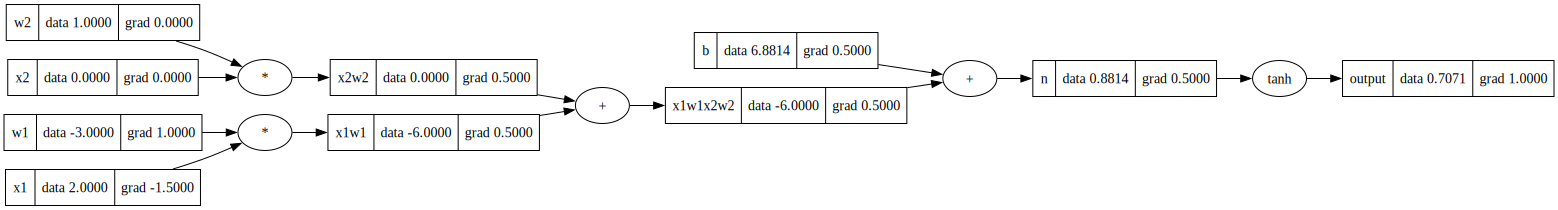

In [19]:
o.backward_prop()
draw_dot(o)